In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
from PIL import Image

# source: https://github.com/cjmcgill/characterizing_uncertainty_scripts/blob/main/figure_scripts/figure_8.py
from multiprocessing import Pool, cpu_count

def compute_interval(args):
    upper, unce, pred, true = args
    ctr = 0
    for u, p, t in zip(unce, pred, true):
        s = np.sqrt(u)
        i = stats.norm.interval(confidence=upper, loc=p, scale=s)
        if t >= i[0] and t <= i[1]:
            ctr += 1
    return ctr

def compute_auce(pred, unce, true, q=10, num_processes=None):
    if num_processes is None:
        num_processes = cpu_count()  # Use all available CPUs if not specified

    calibration_x = [0]
    calibration_y = [0]
    calibration_y_oracle = [0]
    auce = 0

    # Prepare arguments for each process
    args = [( (i+1)*1/q, unce, pred, true) for i in range(q)]

    with Pool(processes=num_processes) as pool:
        results = pool.map(compute_interval, args)

    for i in range(q):
        upper = (i + 1) * 1 / q
        ctr = results[i]
        calibration_x.append(upper)
        calibration_y.append(ctr / len(unce))
        calibration_y_oracle.append(upper)
        auce += abs(ctr / len(unce) - upper) * 1 / q

    return auce, calibration_x, calibration_y, calibration_y_oracle

def create_subplot_auce(system, true, pred, unce, xlabel=False, ylabel=False):
    target_name_dict = {"1syh score":"1SYH score (-)", "4lde score":"4LDE score (-)", "6y2f score":"6Y2F score (-)",
                    "singlet-triplet value":"Singlet-triplet gap (eV)", "oscillator strength":"Oscillator strength (-)", 
                    "abs_diff_vee":"Abs. diff.of VEE (eV)",
                    "activation_energy":"Activation energy (kcal/mol)", "reaction_energy":"Reaction energy (kcal/mol)",
                    "1syh_score":"1SYH score (-)", "4lde_score":"4LDE score (-)", "6y2f_score":"6Y2F score (-)",
                    "singlet-triplet_value":"Singlet-triplet gap (eV)", "oscillator_strength":"Oscillator strength (-)", 
                    'similarity_Aripiprazole':'Similarity to Aripiprazole (-)',
                    'similarity_Albuterol': 'Similarity to Albuterol (-)', 'similarity_Mestranol':'Similarity to Mestranol (-)',
                    'similarity_Tadalafil': 'Similarity to Tadalafil (-)', 'similarity_Sildenafil':'Similarity to Sildenafil (-)',
                    'similarity_Camphor': 'Similarity to Camphor (-)', 'similarity_Menthol': 'Similarity to Menthol (-)',
                    'similarity_Fexofenadine': 'Similarity to Fexofenadine (-)', 'similarity_Ranolazine': 'Smilarity to Ranolazine (-)',
                    'logP': 'logP (-)', "tpsa": "TPSA ($\AA^2$)"}
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(target_name_dict[system],fontsize=15)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)), fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    if xlabel:
        plt.xlabel("Confidence level", fontsize=14)
    if ylabel:
        plt.ylabel("Proportion of data within\nthe confidence interval", fontsize=14)
    print(system, auce)


## Plot all auce plots

singlet-triplet value 0.02462804802574575
oscillator strength 0.07724904072286175
abs_diff_vee 0.02779799480133679
1syh score 0.043814839133289554
4lde score 0.03307616546290216
6y2f score 0.014179251477347344
activation_energy 0.029193654446818998
reaction_energy 0.055609896432681244
similarity_Aripiprazole 0.07353
similarity_Albuterol 0.027054999999999996
similarity_Mestranol 0.02577
similarity_Tadalafil 0.09423
similarity_Sildenafil 0.06853
similarity_Camphor 0.076095
similarity_Menthol 0.076135
similarity_Fexofenadine 0.06087499999999999
similarity_Ranolazine 0.08772
logP 0.028215
tpsa 0.013434999999999996


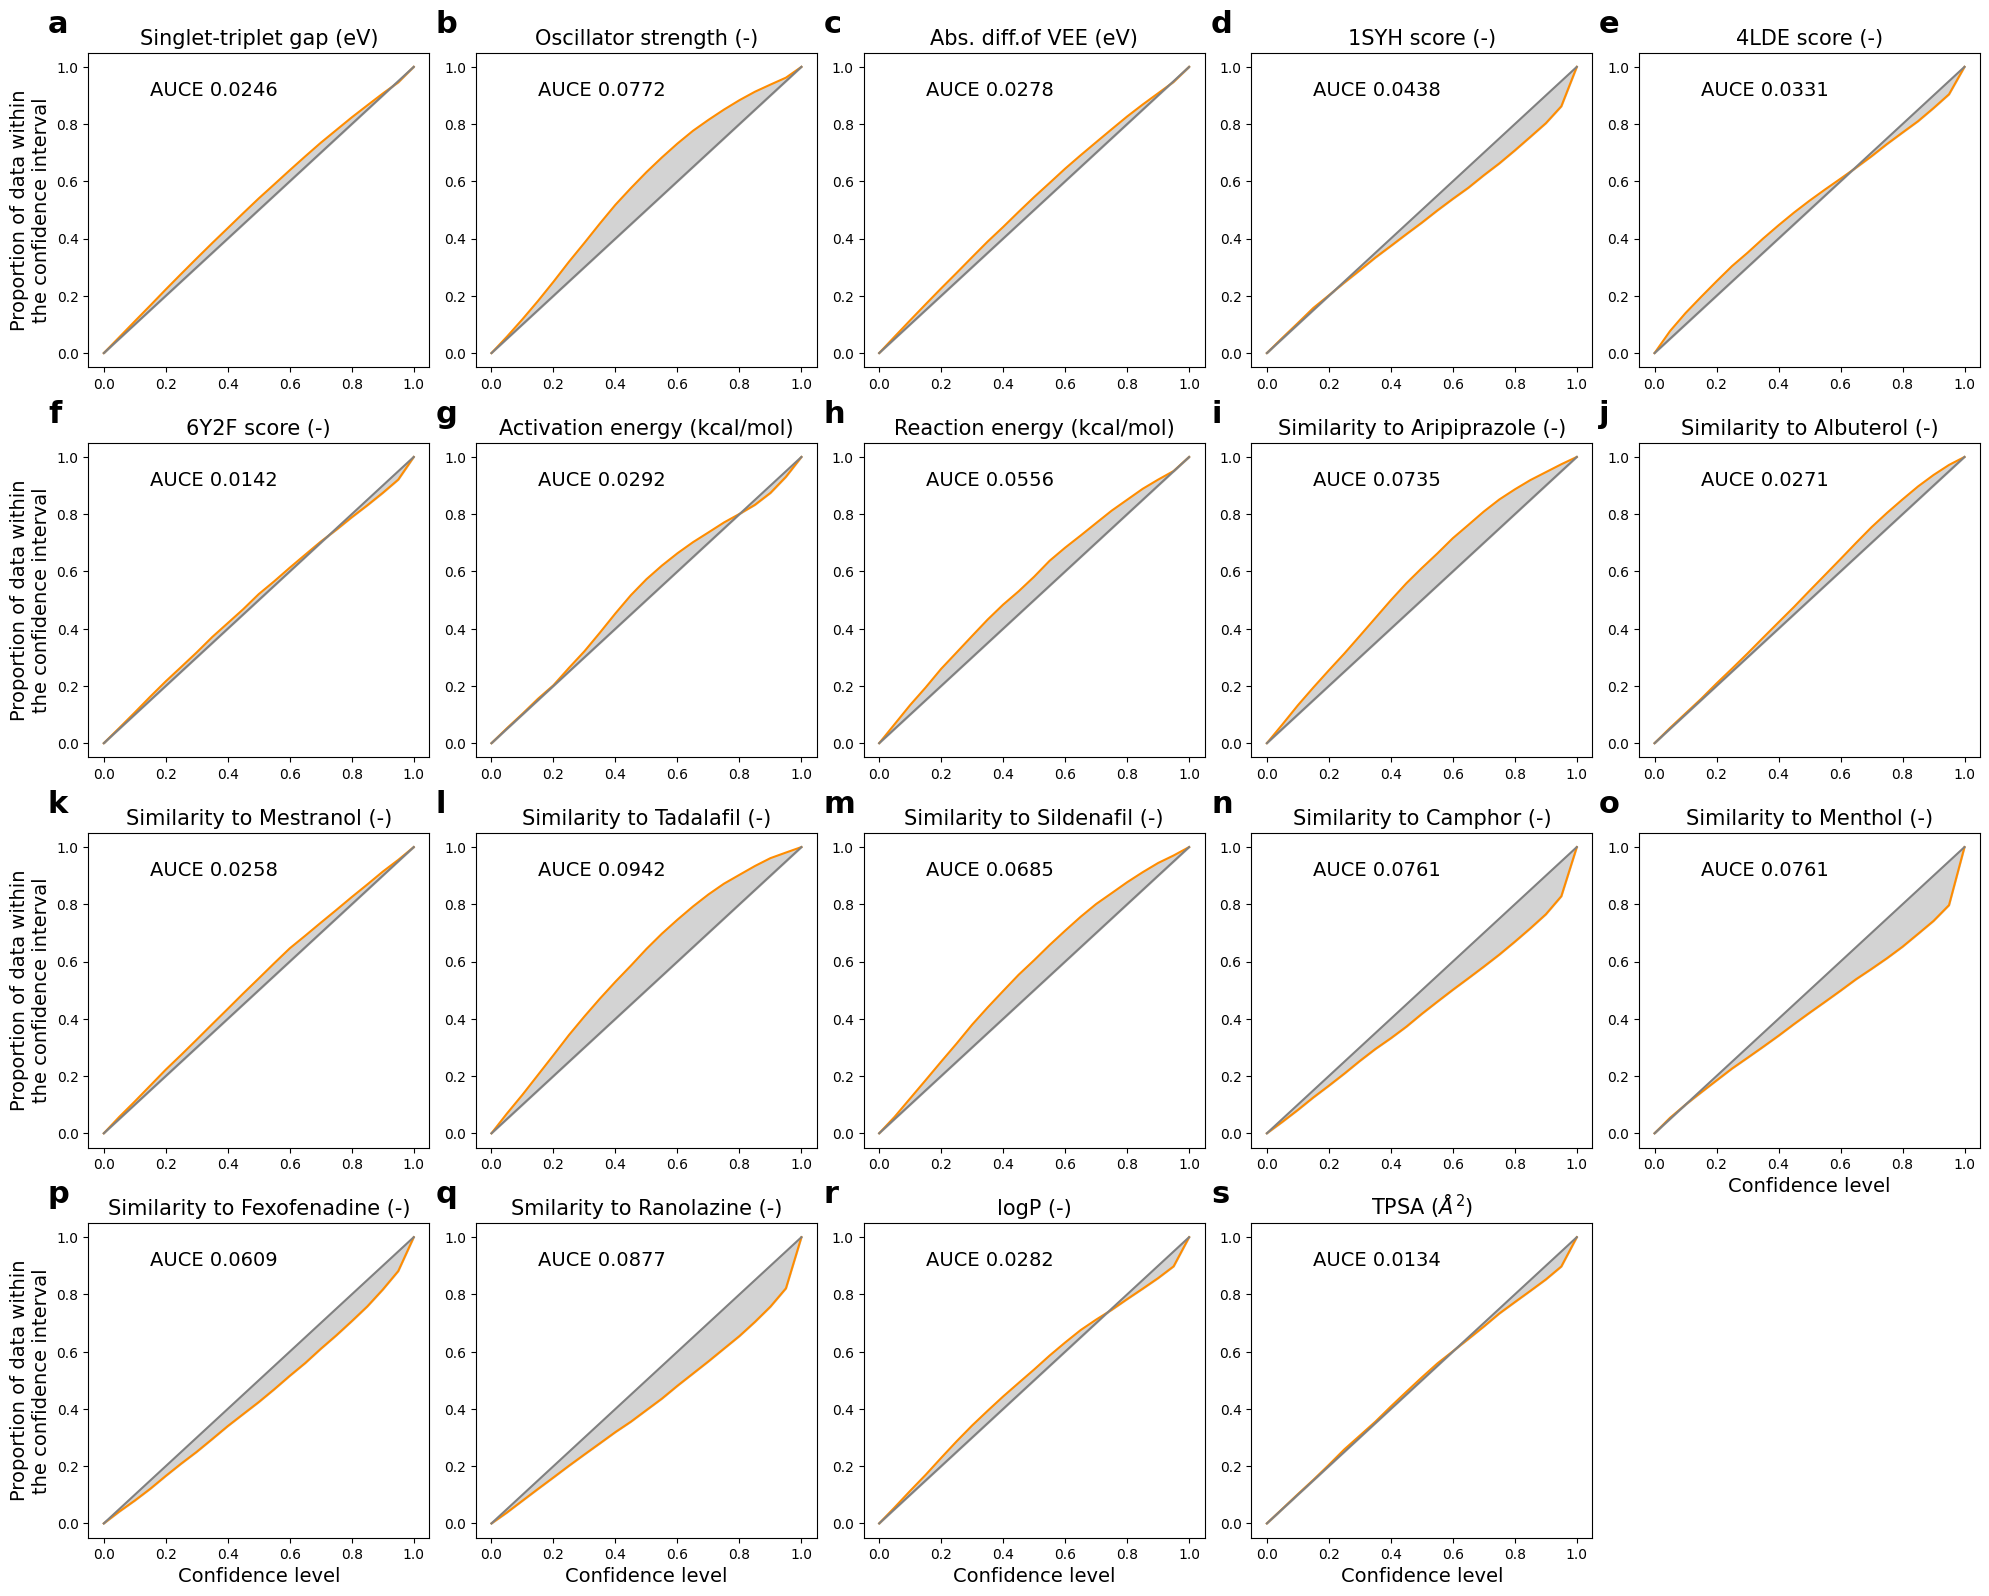

In [12]:
dataset_target = [("organic_emitter", "singlet-triplet value"), ("organic_emitter", "oscillator strength"), ("organic_emitter", "abs_diff_vee"),
                  ("docking", "1syh score"), ("docking", "4lde score"), ("docking", "6y2f score"),
                  ("reactivity", "activation_energy"), ("reactivity", "reaction_energy")]
model_dict = {"docking":"chemprop_unc/save_models/docking_evidential/fold_0",
              "organic_emitter":"chemprop_unc/save_models/organic_emitter_ensemble_mve/fold_0",
              "reactivity":"chemprop_unc/save_models/reactivity_evidential/fold_0"}
uncertainty_method_dict = {"docking": "evidential_total_uncal_var",
                           "organic_emitter": "mve_uncal_var",
                           "reactivity": "evidential_total_uncal_var"}

target_model_columns = [('similarity_Aripiprazole', 'trial_30'),
       ('similarity_Albuterol', 'trial_30'), ('similarity_Mestranol', 'trial_30'),
       ('similarity_Tadalafil', 'trial_30'), ('similarity_Sildenafil', 'trial_30'), 
       ('similarity_Camphor', 'trial_24'), ('similarity_Menthol', 'trial_20'),
       ('similarity_Fexofenadine', 'trial_24'), ('similarity_Ranolazine', 'trial_19'),
       ('logP', 'trial_3'), ('tpsa', 'trial_24')]

mixed_info = dataset_target + target_model_columns
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k','l', 'm','n','o', 'p','q','r','s']

fig, axs = plt.subplots(4, 5, figsize=(20, 16), dpi=100)

# for i, (dataset, target) in enumerate(dataset_target):
for i, ax in enumerate(axs.flat):
    if i == 19:
        ax.axis('off')
        break
    xlabel = False
    ylabel = False
    j = i + 1
    if i in [0,5,10,15]:
        ylabel=True
    if i in [14,15,16,17,18]:
        xlabel=True
    plt.subplot(4,5,int(j))

    if i < 8: # Tartarus
        dataset, target = mixed_info[i]
        model_path = model_dict[dataset]
        uncertainty_method = uncertainty_method_dict[dataset]
        unc_name = target + "_" + uncertainty_method
        true_df = pd.read_csv(os.path.join(model_path, "test_full.csv"))
        pred_df = pd.read_csv(os.path.join(model_path, "test_unc.csv"))
        true = true_df[target]
        pred = pred_df[target]
        unce = pred_df[unc_name]
    else:
        target, model = mixed_info[i]
        unc_name = target + "_" + "evidential_total_uncal_var"
        model_path = f"chemprop_unc/save_models/guacamol/{target}/{model}/fold_0"
        true_df = pd.read_csv("guacamol_benchmark/guacamol_dataset/guacamol_sample_test.csv")
        pred_df = pd.read_csv(os.path.join(model_path, "test_unc.csv"))
        true = true_df[target]
        pred = pred_df[target]
        unce = pred_df[unc_name]
    create_subplot_auce(target, true, pred, unce, xlabel=xlabel, ylabel=ylabel)
    plt.text(-0.18, 1.20, labels[i], color='black', fontsize=22, va='top', ha='left', weight="bold")

plt.tight_layout()
plt.savefig("figures/finals/auce_plots/overall_auce.svg", format="svg")